# Exp012: Grammar Detection - Automatic Approach with GPT-4o

In [43]:
from dotenv import load_dotenv
import os
load_dotenv()
from openai import OpenAI
import requests
import json
import re
import numpy as np
import random
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
from tqdm.notebook import tqdm
from itertools import combinations
import pandas as pd

import sys
sys.path.append("../source")
import helpers
import data
import models
import api

import importlib
importlib.reload(models)

client = OpenAI()
egp = helpers.get_egp()

Ask GPT4 for regular expressions of the corpus search.

In [95]:
# sample rule
rule = egp.sample(1).iloc[0]
# compose prompt
prompt = f"""I want to find sentences with {" ".join(rule['Can-do statement'].split(" ")[2:]).replace(".","")} (category: {rule['SuperCategory']}: {rule['SubCategory']}) a text.
What are Python regular expressions I should search for?
Return a json array with basic regex: {{ "search": [regex1, regex2, ...] }}."""
print(prompt)
# query API
messages = [{ "role": "user", "content": prompt}]
response = client.chat.completions.create(
    model="gpt-4-turbo-preview",#"gpt-3.5-turbo-1106",#os.getenv("OPENAI_DEFAULT_MODEL"),
    messages=messages,
    response_format={ "type": "json_object" },
    n=1,
    max_tokens=512,
)
#print(response.choices[0].message.content)

matched_strings = set()
all_expressions = set()
strings_to_search = rule['Example'].split("\n\n")

for choice in response.choices:
    all_expressions.update(json.loads(choice.message.content)['search'])
for pattern in all_expressions:
    print(pattern)

for string in strings_to_search:
    for pattern in all_expressions:
        if re.search(pattern.replace("\x08", "").replace("\x09", "").replace("++", "+"), string, re.IGNORECASE):
            matched_strings.add(string)
            break

print(rule['Example'])

print(len(matched_strings)/len(strings_to_search))

other_rule = egp.sample(1).iloc[0]
string_prob_not_to_match = other_rule['Example'].split("\n\n")
for string in string_prob_not_to_match:
    for pattern in all_expressions:
        if re.search(pattern.replace("\x08", "").replace("\x09", "").replace("++", "+"), string, re.IGNORECASE):
            print(string)
            break


I want to find sentences with the singular reflexive pronouns 'myself', 'yourself', 'himself' and 'herself' for emphasis (category: PRONOUNS: reflexive) a text.
What are Python regular expressions I should search for?
Return a json array with basic regex: { "search": [regex1, regex2, ...] }.
\bhimself\b
\byourself\b
\bmyself\b
\bherself\b
The best solution will be if you decide yourself what to do. 

I think it was the director himself who guided the actress through our wonderful school gardens to film the opening scene there. 

The food was delicious, especially the cake, which Sandra had cooked herself.
1.0
I myself, having been educated the hard way, would specifically insist on them getting the best possible school education. 


In [2]:
def get_response(prompt, stop=[], max_tokens=64, model=None):
    response = client.chat.completions.create(
        model=model if model else "gpt-4o",
        messages=[{ "role": "user", "content": prompt}],
        temperature=0,
        max_tokens=max_tokens,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
        n=1,
        stop=stop
    )
    return response.choices[0].message.content

In [3]:
def describe_skill(rule):
    return f"""Learn this grammar skill from the description and the examples:
{rule['guideword']}: {rule['Can-do statement']}
Category: {rule['SuperCategory']}
SubCategory: {rule['SubCategory']}
CEFR Level: {rule['Level']}
{f"Lexical Range: {int(rule['Lexical Range'])}/3" if not np.isnan(rule['Lexical Range']) else ""}
Examples:
{rule['Example']}"""

In [4]:
def get_words(rule):
    prompt = f"""
{describe_skill(rule)}

Which words and combinations of words should I search for in a text to find other example sentences of this grammar pattern? Only output the words as a list.
"""
    response = get_response(prompt)
    words = [res.replace("- ", "") for res in response.split("\n")]
    words = [word for word in words if word != ""]
    return words

In [5]:
def get_questions(rule):
    prompt = f"""
{describe_skill(rule)}

Create a checklist with questions that all necessarily need to be answered with "Yes" to judge whether that skill is used in a sentence. Only return the enumerated questions."""

    return get_response(prompt, max_tokens=256)

In [6]:
def detect_prompt(sentence, questions):  
    return f"""
Sentence:
{sentence}

Questions:
{questions}

Given the sentence, answer the given questions with either a clear "Yes" or "No". Only return the enumerated responses.
"""

In [7]:
def judge(sentences, questions, verbose=True, max_positives=25, max_negatives=25):
    positives = []
    negatives = []
    for probe in tqdm(sentences):
        if verbose: print(probe)
        response = get_response(detect_prompt(probe, questions))
        if verbose: print(response)
        if re.search(r"\bNo\b", response):
            negatives.append(probe)
        else:
            positives.append(probe)
        if len(positives) > max_positives: break
        if len(negatives) > max_negatives: break
    return positives, negatives

In [28]:
def search_corpus(words, sents):
    results = {}
    for sentence in tqdm(sents):
        count = 0
        for word in words:
            if bool(re.search(r"\b" + re.escape(word.lower()) + r"\b", sentence.lower())):
                count = count/2 + 1 + word.count(' ') / 4 + int(word in sentence) / 8
        results[sentence] = count

    hits = [key for key, value in results.items() if value > 0]
    sorted_sentences = sorted(hits, key=lambda x: results[x], reverse=True)
    return results, sorted_sentences, hits

In [9]:
# model training
def get_trained_classifier(positive, negative, others, classifier, ratio=1, verbose=False):
    dataset = data.get_dataset(positive, negative, others, models.bert_tokenizer, 64, ratio*len(positive)/len(negative), verbose=verbose) 
    train_dataloader, val_dataloader = data.get_loaders(dataset)
    _, val_metrics = models.train(classifier, train_dataloader, val_dataloader, num_epochs=None, verbose=verbose, leave=not verbose)
    return classifier, val_metrics

In [10]:
sents = data.get_mixed_sentences(1000000)
sents = set(sents) # remove duplicates

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:28<00:00,  7.01s/it]


In [11]:
max_batches = 16
batch_size = 256
sentences = list(sents)
encoded_inputs = models.bert_tokenizer(sentences[:12*max_batches*batch_size], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
encoded_inputs['sentences'] = sentences[:12*max_batches*batch_size]

In [31]:
def get_new_candidates(classifier, positives, encoded_inputs, batch_size = 256, num_examples = 32000, max_positive=25):
    shuffled_index = np.random.permutation(encoded_inputs['input_ids'].size(0))
    for key, value in encoded_inputs.items():
        encoded_inputs[key] = value[shuffled_index] if isinstance(value, Tensor) else [value[i] for i in shuffled_index]
    
    corpus_dataset = TensorDataset(encoded_inputs['input_ids'], encoded_inputs['attention_mask'])
    corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)
    scores, tokens, num_batches = models.score_corpus(classifier, corpus_dataloader, max_positive=max_positive, max_batches=num_examples//batch_size, threshold=0.5)
    hits = list(zip(scores, tokens, encoded_inputs['sentences'][:len(scores)]))
    subset = [(score, token, sample) for score, token, sample in hits if
         score > 0.5 and not sample in positives]
    return [sample for _, _, sample in subset], num_batches * batch_size

## Auto training flow

In [66]:
rules = egp[egp['SubCategory'].isin(["would", "negation", "superlatives"])].copy()
rules['sanity_passed'] = False
rules['search_matches'] = 0
rules['search_precision'] = 0
rules['f1_scores'] = [[]] * len(rules)
rules['detector_match_ratio'] = [[]] * len(rules)
rules['detector_precisions'] = [[]] * len(rules)

In [91]:
len(rules.loc[1192:])

13

In [92]:
for idx, rule in rules.loc[1192:].iterrows():
    rules.to_json("../data/auto_training.json")
    print(f"""{rule['guideword']}: {rule['Can-do statement']}
    {rule['Example']}""")
    # ask GPT for search strings
    words = get_words(rule)
    print(words)
    # ask GPT for detection questions
    questions = get_questions(rule)
    print(questions)
    # do a sanity check of the questions with the given examples
    positives, negatives = judge(rule['Example'].split("\n\n"), questions)
    if not len(negatives)==0:
        continue
    rules.at[idx, 'sanity_passed'] = True
    # Find candidates in corpus
    results, sorted_sentences, hits = search_corpus(words, sents)
    rules.at[idx, 'search_matches'] = len(hits)
    others = list(sents.difference(set([key for key, value in results.items() if value == 0])))
    print(sorted_sentences[:10])
    # judge candidates
    positives = []
    negatives = []
    
    candidates = sorted_sentences[:50]
    #random.shuffle(candidates)
    candidates = list(set(candidates).difference(set(positives+negatives)))
    new_positives, new_negatives = judge(candidates, questions)
    if len(new_positives) < 10: continue
    rules.at[idx, 'search_precision'] = len(new_positives) / (len(new_positives)+len(new_negatives))
    if len(new_negatives) == 0: new_negatives = random.sample(others, 1)
    positives = positives + new_positives
    negatives = negatives + new_negatives
     
    # iteratively train classifier
    metrics = {"precision": 0.}
    iterations = 0
    while metrics['precision'] < 0.8 and iterations < 5:
        iterations += 0.2
        classifier = models.RuleDetector(models.bert_encoder).to(models.device)
        classifier, metrics = get_trained_classifier(positives, negatives, others, classifier, ratio=1, verbose=True)
        print(metrics)
        rules.at[idx, 'f1_scores'] = rules.at[idx, 'f1_scores'] + [metrics['f1']]
        if metrics['precision'] == 0.: continue
        # get new candidates
        new_candidates, num_tested = get_new_candidates(classifier, positives, encoded_inputs)
        rules.at[idx, 'detector_match_ratio'] = rules.at[idx, 'detector_match_ratio'] + [len(new_candidates)/num_tested]
        if len(new_candidates) < 5: continue
        iterations += 0.8
        # retrain on new candidates
        new_positives, new_negatives = judge(new_candidates, questions)
        precision = len(new_positives) / (len(new_positives)+len(new_negatives))
        rules.at[idx, 'detector_precisions'] = rules.at[idx, 'detector_precisions'] + [precision]
        print(precision)
        if precision >= 0.8: break
        
        positives = positives + new_positives
        negatives = negatives + new_negatives
    
    models.save_classifier(classifier, rule['#'], "auto_training")

FORM/USE: 'NEVER', INVERTED FRONT POSITION, FOCUS: Can use 'never' in front position followed by an inverted subject (most commonly 'I') + main verb, to give focus. 
    Never have I seen such a realistic and impressive film before. 

Never had I thought that my parents would do this to me.
['Never have I', 'Never had I']
1. Is the word "never" placed at the beginning of the sentence?
2. Is the subject inverted, meaning the subject follows the auxiliary verb?
3. Is the main verb placed after the inverted subject?
4. Does the sentence convey a sense of negation or impossibility?
5. Is the sentence structured to give focus or emphasis to the negation?


  0%|          | 0/2 [00:00<?, ?it/s]

Never have I seen such a realistic and impressive film before. 
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
Never had I thought that my parents would do this to me.
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

[]


0it [00:00, ?it/s]

FORM/USE: 'NEITHER ... NOR': Can use 'neither ... nor' to connect two words, phrases or clauses, often to give emphasis or focus.
    Neither you nor I would like that. 

We can neither eat nor drink during the lessons. 

I have neither climbed nor surfed before, so that would be very exciting for me.
['neither', 'nor']
1. Does the sentence contain the word "neither"?
2. Does the sentence contain the word "nor"?
3. Are "neither" and "nor" used to connect two words, phrases, or clauses?
4. Is the sentence structured to emphasize or focus on the negation of both elements connected by "neither" and "nor"?


  0%|          | 0/3 [00:00<?, ?it/s]

Neither you nor I would like that. 
1. Yes
2. Yes
3. Yes
4. Yes
We can neither eat nor drink during the lessons. 
1. Yes
2. Yes
3. Yes
4. Yes
I have neither climbed nor surfed before, so that would be very exciting for me.
1. Yes
2. Yes
3. Yes
4. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

['As a man of medium height in the West, he keeps a powerful but elegant figure, looking neither lanky nor stout.', 'I want my ideal city to be neither too big nor too small.', 'Unfortunately, neither Nietzsche’s ideas about the nature of value creation nor his suggestions about what specific values should be “created” have seemed as clear to readers as his negative critique of traditional values.', 'On such views, and in contrast to the Aristotelian picture, basic self-awareness is neither sensory in nature nor dependent on the awareness of other things.', "It's neither too hot nor too cold.", 'The case is neither supported by facts nor does it have valid legal grounds, he added.', 'As our sole agency, you will neither handle the same or similar products of other origins nor re-export our goods to any other area outside your own.', 'Conversely, truth-value realism does not by itself entail Existence and thus implies neither object realism nor platonism.', 'But he maintained neither he

  0%|          | 0/50 [00:00<?, ?it/s]

As our sole agency, you will neither handle the same or similar products of other origins nor re-export our goods to any other area outside your own.
1. Yes
2. Yes
3. Yes
4. Yes
I want my ideal city to be neither too big nor too small.
1. Yes
2. Yes
3. Yes
4. Yes
I've seen 21 Jump Street but not the sequel, nor have I seen Magic Mike although I know my sister loved that one!
1. No
2. Yes
3. No
4. No
The images were taken in different places, with very different lighting and of the 200 photographs we took during our holiday no orbs appeared on any other photograph -- nor indeed on any photograph ever taken on that camera before or since.
1. No
2. Yes
3. No
4. No
The court case began in Paris on Wednesday afternoon, though neither Johansson nor Delacourt was present.
1. Yes
2. Yes
3. Yes
4. Yes
Yes, but it's a strange situation...it's neither a brother, a male sibling, nor a sister, a female sibling....
1. Yes
2. Yes
3. Yes
4. Yes
But he maintained neither he nor the organization was cor

  1%|█                                                                                                     | 1/100 [00:00<00:12,  7.68it/s]

Training loss: 0.718863308429718
Val loss: 0.7145719826221466



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 37.53it/s]

Training loss: 0.7115728259086609



  2%|██                                                                                                    | 2/100 [00:00<00:12,  7.75it/s]

Val loss: 0.7080439329147339



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.86it/s]


Training loss: 0.6673271656036377
Val loss: 0.7058454751968384
{'accuracy': 0.453, 'f1': 0.567, 'precision': 0.404}


  0%|                                                                                                              | 0/192 [00:00<?, ?it/s]


  0%|          | 0/217 [00:00<?, ?it/s]

Why don't we fix the amount first and ask a restaurant to provide a meal for that price?
1. No
2. No
3. No
4. No
Yeah another fact is that it only takes 3 months 90 days for them to seed and sprout
1. No
2. No
3. No
4. No
How do you get along with your boss?
1. No
2. No
3. No
4. No
May I see your bill please?
1. No
2. No
3. No
4. No
It was directed by Steve Spielberg, was pretty good at the time it came out.
1. No
2. No
3. No
4. No
It's not over in Steubenville, Ohio.
1. No
2. No
3. No
4. No
Beer dates back to at least the 5th millennium BC in Iran - was recorded in written history of ancient Egypt even - so it's been a staple for a LONG time
1. No
2. No
3. No
4. No
﻿You can be Aagot, Arney or Ásfríður; Baldey, Bebba or Brá.
1. No
2. No
3. No
4. No
I like that too, but I think my favorite might be jazz funk style dancing from a few decades ago.
1. No
2. No
3. No
4. No
I need to see if we can get together today.
1. No
2. No
3. No
4. No
I have to laugh when I see people do stuff like tha

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.06it/s]

Training loss: 0.7872307300567627
Val loss: 0.7329935630162557



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.26it/s]


Training loss: 0.7652104496955872


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.66it/s]

Val loss: 0.7116024295488993



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.92it/s]


Training loss: 0.7101175785064697


  3%|███                                                                                                   | 3/100 [00:00<00:16,  6.05it/s]

Val loss: 0.6926064491271973



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.55it/s]

Training loss: 0.687937319278717



  4%|████                                                                                                  | 4/100 [00:00<00:15,  6.26it/s]

Val loss: 0.675202210744222



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.76it/s]

Training loss: 0.6699646711349487



  5%|█████                                                                                                 | 5/100 [00:00<00:14,  6.35it/s]

Val loss: 0.65921950340271



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.11it/s]

Training loss: 0.6387333869934082



  6%|██████                                                                                                | 6/100 [00:00<00:14,  6.42it/s]

Val loss: 0.6468717058499655



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.02it/s]

Training loss: 0.6125916242599487



  7%|███████▏                                                                                              | 7/100 [00:01<00:14,  6.46it/s]

Val loss: 0.6360419789950053



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.68it/s]

Training loss: 0.5982389450073242



  8%|████████▏                                                                                             | 8/100 [00:01<00:14,  6.48it/s]

Val loss: 0.6260575652122498



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.08it/s]

Training loss: 0.5762506127357483



  9%|█████████▏                                                                                            | 9/100 [00:01<00:13,  6.52it/s]

Val loss: 0.6175864736239115



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.55it/s]

Training loss: 0.5650165677070618



 10%|██████████                                                                                           | 10/100 [00:01<00:13,  6.56it/s]

Val loss: 0.6100877722104391



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.29it/s]

Training loss: 0.5402582883834839



 11%|███████████                                                                                          | 11/100 [00:01<00:13,  6.58it/s]

Val loss: 0.6030463576316833



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.39it/s]

Training loss: 0.5109125971794128



 12%|████████████                                                                                         | 12/100 [00:01<00:13,  6.57it/s]

Val loss: 0.5961477557818095



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.01it/s]

Training loss: 0.5029046535491943



 13%|█████████████▏                                                                                       | 13/100 [00:02<00:13,  6.55it/s]

Val loss: 0.589339037736257



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.07it/s]

Training loss: 0.46412011981010437



 14%|██████████████▏                                                                                      | 14/100 [00:02<00:13,  6.55it/s]

Val loss: 0.5818559527397156



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.95it/s]

Training loss: 0.4607371389865875



 15%|███████████████▏                                                                                     | 15/100 [00:02<00:12,  6.54it/s]

Val loss: 0.574853777885437



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.76it/s]

Training loss: 0.44282272458076477



 16%|████████████████▏                                                                                    | 16/100 [00:02<00:12,  6.55it/s]

Val loss: 0.5686873197555542



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.42it/s]

Training loss: 0.40471699833869934



 17%|█████████████████▏                                                                                   | 17/100 [00:02<00:12,  6.57it/s]

Val loss: 0.5630708734194437



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.61it/s]

Training loss: 0.3907023072242737



 18%|██████████████████▏                                                                                  | 18/100 [00:02<00:12,  6.60it/s]

Val loss: 0.5574549039204916



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.41it/s]

Training loss: 0.3660668432712555


Val loss: 0.552832841873169
{'accuracy': 0.743, 'f1': 0.537, 'precision': 0.55}


  1%|▌                                                                                                     | 1/192 [00:00<01:38,  1.94it/s]


  0%|          | 0/27 [00:00<?, ?it/s]

Do you know any other fun facts about the show?
1. No
2. No
3. No
4. No
Not sure about that but paleontology would be my favorite.At 1.3 million described species insects account for more than two-thirds of all known organisms, date back some 400 million years, and have many kinds of interactions with humans and other forms of life on earth.
1. No
2. No
3. No
4. No
Some other advocates think that life extension is a better goal in the short term.
1. No
2. No
3. No
4. No
It is true with out Steve Wozniak, jobs would have never had a job and would have to work at a grocery store his entire life?
1. No
2. No
3. No
4. No
What does he need?
1. No
2. No
3. No
4. No
A decade from now, hopefully, she 'll have some stability in her life and maybe a husband, and they can be somewhere in Montana and start over, he said.
1. No
2. No
3. No
4. No
Well, last night when I returned from the theatre, I found that I'd lost my wallet.
1. No
2. No
3. No
4. No
They want to shrink the size of government and 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.59it/s]

Training loss: 0.6800282597541809



  1%|█                                                                                                     | 1/100 [00:00<00:20,  4.77it/s]

Val loss: 0.6527947982152303



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.31it/s]


Training loss: 0.65955650806427


  2%|██                                                                                                    | 2/100 [00:00<00:19,  5.04it/s]

Val loss: 0.6408702532450358



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Training loss: 0.6381526589393616


  3%|███                                                                                                   | 3/100 [00:00<00:18,  5.14it/s]

Val loss: 0.6308056513468424



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Training loss: 0.6158397197723389


  4%|████                                                                                                  | 4/100 [00:00<00:18,  5.18it/s]

Val loss: 0.6215521097183228



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Training loss: 0.6014212965965271


  5%|█████                                                                                                 | 5/100 [00:00<00:18,  5.20it/s]

Val loss: 0.6143250465393066



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Training loss: 0.5869718790054321


  6%|██████                                                                                                | 6/100 [00:01<00:17,  5.23it/s]

Val loss: 0.6084834734598795



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.49it/s]


Training loss: 0.5593178868293762


  7%|███████▏                                                                                              | 7/100 [00:01<00:17,  5.25it/s]

Val loss: 0.6014945109685262



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.35it/s]


Training loss: 0.5379907488822937


  8%|████████▏                                                                                             | 8/100 [00:01<00:17,  5.27it/s]

Val loss: 0.5933342178662618



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Training loss: 0.506867527961731


  9%|█████████▏                                                                                            | 9/100 [00:01<00:17,  5.26it/s]

Val loss: 0.5852837959925333



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Training loss: 0.5029070377349854


 10%|██████████                                                                                           | 10/100 [00:01<00:17,  5.26it/s]

Val loss: 0.5781011382738749



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Training loss: 0.4754924774169922


 11%|███████████                                                                                          | 11/100 [00:02<00:16,  5.26it/s]

Val loss: 0.5698854724566141



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Training loss: 0.4536535143852234


 12%|████████████                                                                                         | 12/100 [00:02<00:16,  5.24it/s]

Val loss: 0.5613651871681213



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.51it/s]


Training loss: 0.4343988299369812


 13%|█████████████▏                                                                                       | 13/100 [00:02<00:16,  5.26it/s]

Val loss: 0.5539978742599487



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.43it/s]


Training loss: 0.4156514108181


 14%|██████████████▏                                                                                      | 14/100 [00:02<00:16,  5.27it/s]

Val loss: 0.5473147928714752



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Training loss: 0.40067535638809204


 15%|███████████████▏                                                                                     | 15/100 [00:02<00:16,  5.25it/s]

Val loss: 0.541666179895401



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.21it/s]


Training loss: 0.3673957884311676


Val loss: 0.5368642111619314
{'accuracy': 0.821, 'f1': 0.37, 'precision': 0.714}


  5%|█████▎                                                                                               | 10/192 [00:02<00:51,  3.52it/s]


  0%|          | 0/26 [00:00<?, ?it/s]

I forgot what I put up with in that case.
1. No
2. No
3. No
4. No
Makes sense, you'd only be able to use what was available to you before we had such established international trade like today.
1. No
2. No
3. No
4. No
The theories about how she met her end are countless.
1. No
2. No
3. No
4. No
Take as much as you want.
1. No
2. No
3. No
4. No
The couple’s lawyer, Aurélien Hamelle, had told the Paris court it was necessary to block the “highly intimate” images of the duchess without her bikini top as she was a “young woman, not an object”.
1. No
2. No
3. No
4. No
She had done the same thing.
1. No
2. No
3. No
4. No
It's a close one and, oh no!
1. No
2. No
3. No
4. No
My top priority is ending the mass surveillance, digital surveillance, of millions and millions of law- abiding Americans.” 
Feinstein unexpectedly announced that she was “totally opposed” to the foreign leader spying of the sort the NSA conducts of German Chancellor Angela Merkel.
1. No
2. No
3. No
4. No
Yes, you are resp

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.06it/s]

Training loss: 0.8466519117355347



  1%|█                                                                                                     | 1/100 [00:00<00:25,  3.92it/s]

Val loss: 0.7474669218063354



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.41it/s]

Training loss: 0.7804796695709229



  2%|██                                                                                                    | 2/100 [00:00<00:23,  4.09it/s]

Val loss: 0.707363173365593



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.81it/s]

Training loss: 0.739723265171051



  3%|███                                                                                                   | 3/100 [00:00<00:22,  4.22it/s]

Val loss: 0.6765315979719162



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]

Training loss: 0.685306191444397



  4%|████                                                                                                  | 4/100 [00:00<00:22,  4.30it/s]

Val loss: 0.6515705734491348



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.47it/s]


Training loss: 0.6508876085281372


  5%|█████                                                                                                 | 5/100 [00:01<00:21,  4.32it/s]

Val loss: 0.6288404762744904



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.07it/s]

Training loss: 0.6308726668357849



  6%|██████                                                                                                | 6/100 [00:01<00:21,  4.32it/s]

Val loss: 0.6086858958005905



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.09it/s]


Training loss: 0.5981590747833252


  7%|███████▏                                                                                              | 7/100 [00:01<00:21,  4.34it/s]

Val loss: 0.5905549079179764



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.65it/s]

Training loss: 0.5696215033531189



  8%|████████▏                                                                                             | 8/100 [00:01<00:21,  4.34it/s]

Val loss: 0.5742557048797607



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.30it/s]

Training loss: 0.5323861837387085



  9%|█████████▏                                                                                            | 9/100 [00:02<00:20,  4.35it/s]

Val loss: 0.5593163669109344



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.34it/s]

Training loss: 0.5120950937271118



 10%|██████████                                                                                           | 10/100 [00:02<00:20,  4.37it/s]

Val loss: 0.5455855876207352



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.80it/s]

Training loss: 0.4823913872241974



 11%|███████████                                                                                          | 11/100 [00:02<00:20,  4.36it/s]

Val loss: 0.532453678548336



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.81it/s]

Training loss: 0.4708597958087921



 12%|████████████                                                                                         | 12/100 [00:02<00:20,  4.37it/s]

Val loss: 0.5203604251146317



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.01it/s]

Training loss: 0.44544607400894165



 13%|█████████████▏                                                                                       | 13/100 [00:03<00:19,  4.37it/s]

Val loss: 0.508843682706356



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.15it/s]

Training loss: 0.41758546233177185



 14%|██████████████▏                                                                                      | 14/100 [00:03<00:19,  4.37it/s]

Val loss: 0.49831488728523254



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.21it/s]

Training loss: 0.3954313397407532



 15%|███████████████▏                                                                                     | 15/100 [00:03<00:19,  4.38it/s]

Val loss: 0.4882311299443245



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.70it/s]

Training loss: 0.3760020136833191



 16%|████████████████▏                                                                                    | 16/100 [00:03<00:19,  4.37it/s]

Val loss: 0.47854670137166977



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.16it/s]

Training loss: 0.35822421312332153



 17%|█████████████████▏                                                                                   | 17/100 [00:03<00:18,  4.37it/s]

Val loss: 0.4695127606391907



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.95it/s]

Training loss: 0.34074893593788147



 18%|██████████████████▏                                                                                  | 18/100 [00:04<00:18,  4.37it/s]

Val loss: 0.4612520933151245



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.94it/s]


Training loss: 0.31518325209617615


 19%|███████████████████▏                                                                                 | 19/100 [00:04<00:18,  4.38it/s]

Val loss: 0.4536313861608505



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.00it/s]

Training loss: 0.2952684164047241



 20%|████████████████████▏                                                                                | 20/100 [00:04<00:18,  4.39it/s]

Val loss: 0.44696350395679474



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.05it/s]

Training loss: 0.27555733919143677



 21%|█████████████████████▏                                                                               | 21/100 [00:04<00:18,  4.38it/s]

Val loss: 0.44076158106327057



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.00it/s]

Training loss: 0.26595187187194824



 22%|██████████████████████▏                                                                              | 22/100 [00:05<00:17,  4.37it/s]

Val loss: 0.4351595416665077



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.73it/s]

Training loss: 0.2467927634716034


Val loss: 0.4304097071290016
{'accuracy': 0.861, 'f1': 0.429, 'precision': 1.0}


 10%|██████████▌                                                                                          | 20/192 [00:05<00:46,  3.67it/s]


  0%|          | 0/26 [00:00<?, ?it/s]

The single rooms should be on the second or third floor and the double rooms should face the sea and have enough sunshine.
1. No
2. No
3. No
4. No
A tour of Australia would be relaxing because you'd be doing something different and not working.
1. No
2. No
3. No
4. No
It depends if you fancy somewhere hot or cold.
1. No
2. No
3. No
4. No
Served hot and crispy with lunch.
1. No
2. No
3. No
4. No
A cold bevrage
1. No
2. No
3. No
4. No
she says that after several years of use, it's not working properly.
1. No
2. No
3. No
4. No
It's rather cold this morning, wouldn't you say?
1. No
2. No
3. No
4. No
There's the northeast, which is mild in summer and very cold in winter.
1. No
2. No
3. No
4. No
I really hope it doesn't get cold.
1. No
2. No
3. No
4. No
It’s a romantic notion that may appeal to us but, with the cold light of day falling on the scientific evidence, it’s revealed to be nothing more than a fiction.
1. No
2. No
3. No
4. No
it was cold but near the geysers it was quite warm
1. No

  0%|          | 0/3 [00:00<?, ?it/s]

Neither of us is liable in this case. 
1. Yes
2. Pronoun
3. No
4. Yes
Moreover, none of my friends are interested therefore there is no one I can talk to. 
1. Yes
2. Noun phrase
3. Yes
4. Yes
We even met a French group and as none of them spoke English, we stayed with them to translate what they were asked.
1. Yes
2. Pronoun
3. Yes
4. No
FORM: 'NONE', SUBSTITUTION: Can use negative pronoun 'none' to substitute for subject and object pronouns or noun phrases. ► pronouns: substitution
    In fact, there are none, but the hills that do exist can be dubbed mountains - just because there are none... 

Concerning your question about any special requirements of some students - I am glad that I am able to tell you that there are none this year. 

Problems when using English? None.
['none', 'there are none', 'are none', 'none this year', 'none.']
1. Is the word "none" used in the sentence?
2. Is "none" substituting for a subject or object pronoun, or a noun phrase?
3. Is the sentence expressing

  0%|          | 0/3 [00:00<?, ?it/s]

In fact, there are none, but the hills that do exist can be dubbed mountains - just because there are none... 
1. Yes
2. Yes
3. Yes
4. Yes
Concerning your question about any special requirements of some students - I am glad that I am able to tell you that there are none this year. 
1. Yes
2. Yes
3. Yes
4. Yes
Problems when using English? None.
1. Yes
2. Yes
3. Yes
4. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

['I love Lizards even thou there are none in Antarctica.', 'True, there are none native to where I live either.', 'But in several of those that have been opened there are none, no manuals.', 'There are none in Tennessee.', 'There are none in the Department store and the post office was closed.', 'Oh, of course I did, but none of them was very authentic.', 'No, none of it seems to be available yet.', "I can't believe that none of the news stories make you happy or excited.", 'You know what they say: a friend to all is a friend to none.', 'Some have 4 legs, some have none and have snake-like bodies.']


  0%|          | 0/50 [00:00<?, ?it/s]

I love Lizards even thou there are none in Antarctica.
1. Yes
2. Yes
3. Yes
4. Yes
I couldn't eat none when i was pregannt because it is often prepared with raw seafood :(
1. Yes
2. No
3. Yes
4. No
Well, it's really none of your business.
1. Yes
2. Yes
3. Yes
4. Yes
Well, several orders of monks in medieval Europe were thought to have banned meat for ascetic reasons, but none of them abstained from eating fish.
1. Yes
2. Yes
3. Yes
4. Yes
Left without a refrigerator (none are made in France) or nail clippers, he was forced to chill his food on the window ledge and saw at his toenails with a penknife.
1. Yes
2. Yes
3. Yes
4. Yes
I think I put forward some great ideas, but none of them were accepted.
1. Yes
2. Yes
3. Yes
4. Yes
Yes it was amazing, it's probably one of the most none of his books, way more than Shawshank Redemption.
1. Yes
2. No
3. No
4. No
True, there are none native to where I live either.
1. Yes
2. Yes
3. Yes
4. No
I'm afraid there's none.
1. Yes
2. Yes
3. Yes
4. Yes
Sh

  1%|█                                                                                                     | 1/100 [00:00<00:12,  7.70it/s]

Training loss: 0.703508734703064
Val loss: 0.7779837846755981



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.37it/s]

Training loss: 0.6844179630279541



  2%|██                                                                                                    | 2/100 [00:00<00:12,  8.16it/s]

Val loss: 0.7704775631427765



  3%|███                                                                                                   | 3/100 [00:00<00:11,  8.70it/s]

Training loss: 0.6552560925483704
Val loss: 0.7613931000232697



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.30it/s]


Training loss: 0.6461872458457947


  4%|████                                                                                                  | 4/100 [00:00<00:10,  9.03it/s]

Val loss: 0.7541514039039612



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.25it/s]


Training loss: 0.6166234016418457


  5%|█████                                                                                                 | 5/100 [00:00<00:10,  9.17it/s]

Val loss: 0.747369796037674



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 51.11it/s]


Training loss: 0.6086572408676147


Val loss: 0.7455028891563416
{'accuracy': 0.48, 'f1': 0.606, 'precision': 0.435}


  0%|                                                                                                              | 0/192 [00:00<?, ?it/s]


  0%|          | 0/241 [00:00<?, ?it/s]

I'm afraid I've got a terrible cold and a bad headache.
1. No
2. No
3. No
4. No
Manicole Tan.
1. No
2. No
3. No
4. No
I wish I could get a night shift on my job!
1. No
2. No
3. No
4. No
I could really use one as well, and it's interesting to think that indian cuisine is still evolving even today.
1. No
2. No
3. No
4. No
Golden retrievers are good hunting dogs.
1. No
2. No
3. No
4. No
I'm sure the number is much greater now!
1. No
2. No
3. No
4. No
Do you know when the band was founded?
1. No
2. No
3. No
4. No
So I got it wrong.” 
The line emerging from the Vatican within hours of the announcement was that the Pope’s decision was a brave one.
1. No
2. No
3. No
4. No
dont you have to have a lot of balance or coordination?
1. No
2. No
3. Yes
4. No
I think I have separation anxiety disorder (SAD) because I need to leave my family and find a new place to live but I get so sad and worried about it.
1. No
2. No
3. No
4. No
Santana said when he first came on the scene while walking to his job 

  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.73it/s]

Training loss: 0.7497421503067017
Val loss: 0.7298451662063599



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.44it/s]


Training loss: 0.7342217564582825


  2%|██                                                                                                    | 2/100 [00:00<00:16,  5.98it/s]

Val loss: 0.7231299082438151



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.79it/s]


Training loss: 0.7263748645782471


  3%|███                                                                                                   | 3/100 [00:00<00:15,  6.38it/s]

Val loss: 0.696885367234548



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.96it/s]

Training loss: 0.6875997185707092



  4%|████                                                                                                  | 4/100 [00:00<00:14,  6.64it/s]

Val loss: 0.68205593029658



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.27it/s]

Training loss: 0.6711094379425049


Val loss: 0.6772464712460836
{'accuracy': 0.69, 'f1': 0.083, 'precision': 0.333}


  1%|▌                                                                                                     | 1/192 [00:00<01:37,  1.95it/s]


  0%|          | 0/28 [00:00<?, ?it/s]

Yeah I heard that in the Vatican City especially the laws can be really intense.
1. No
2. No
3. No
4. No
Its very hard to learn about all of the different cases and verdicts.
1. No
2. No
3. No
4. No
it is very rich full of milk cream sugar and eggs!
1. No
2. No
3. No
4. No
He was very kind to give valuable suggestions.
1. No
2. No
3. No
4. No
It is very relaxing for me, just to escape for a bit into another world.
1. No
2. No
3. No
4. No
There was very little traffic, so we got there in less than an hour.
1. No
2. No
3. Yes
4. No
it is very relaxing, in the preparation and afterwards when you can enjoy your garden
1. No
2. No
3. No
4. No
She was born in December 1981, I don't think shes been in too many movies
1. No
2. No
3. Yes
4. No
That's interesting, horror is very captivating to me but sometimes it can frighten me too much.
1. No
2. No
3. No
4. No
Just don'T submit a report to your insurancecompany.
1. No
2. No
3. Yes
4. No
I'd like to see the menu, please.
1. No
2. No
3. No
4. No

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 25.92it/s]

Training loss: 0.7780747413635254



  1%|█                                                                                                     | 1/100 [00:00<00:19,  5.08it/s]

Val loss: 0.7315638860066732



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.48it/s]


Training loss: 0.7463130950927734


  2%|██                                                                                                    | 2/100 [00:00<00:18,  5.29it/s]

Val loss: 0.7103836337725321



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.55it/s]


Training loss: 0.7182323336601257


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.42it/s]

Val loss: 0.6948162317276001



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Training loss: 0.6847913265228271


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.49it/s]

Val loss: 0.6824540495872498



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.98it/s]


Training loss: 0.6678702235221863


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.55it/s]

Val loss: 0.6716892520586649



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.18it/s]


Training loss: 0.642738938331604


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.59it/s]

Val loss: 0.661405106385549



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.74it/s]


Training loss: 0.6277579069137573


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.60it/s]

Val loss: 0.6512157122294108



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.00it/s]


Training loss: 0.611467719078064


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.62it/s]

Val loss: 0.6419670979181925



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Training loss: 0.6002774834632874


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.62it/s]

Val loss: 0.6335507233937582



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.48it/s]


Training loss: 0.5857539176940918


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.62it/s]

Val loss: 0.6257901191711426



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.52it/s]


Training loss: 0.5552932024002075


 11%|███████████                                                                                          | 11/100 [00:01<00:15,  5.61it/s]

Val loss: 0.6186496019363403



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Training loss: 0.5387687087059021


 12%|████████████                                                                                         | 12/100 [00:02<00:15,  5.60it/s]

Val loss: 0.6126343806584676



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.32it/s]


Training loss: 0.5236685872077942


Val loss: 0.6079671184221903
{'accuracy': 0.739, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.11it/s]


Training loss: 0.7335704565048218


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.71it/s]

Val loss: 0.6816670894622803



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.13it/s]


Training loss: 0.6707376837730408


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.67it/s]

Val loss: 0.6610473195711771



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.65it/s]


Training loss: 0.6419641971588135


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.65it/s]

Val loss: 0.6445270975430807



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.38it/s]


Training loss: 0.6028772592544556


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.63it/s]

Val loss: 0.630070964495341



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.47it/s]


Training loss: 0.5857717394828796


  5%|█████                                                                                                 | 5/100 [00:00<00:16,  5.62it/s]

Val loss: 0.6171883940696716



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.22it/s]


Training loss: 0.5616861581802368


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.64it/s]

Val loss: 0.605923593044281



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Training loss: 0.5326434373855591


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.66it/s]

Val loss: 0.5972623626391093



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.36it/s]


Training loss: 0.4893837571144104


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.65it/s]

Val loss: 0.5906960566838583



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.22it/s]


Training loss: 0.45824190974235535


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.61it/s]

Val loss: 0.5854766170183817



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.92it/s]


Training loss: 0.4332186281681061


Val loss: 0.5811598102251688
{'accuracy': 0.739, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.98it/s]


Training loss: 0.8055197596549988


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.54it/s]

Val loss: 0.7528446714083353



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.48it/s]


Training loss: 0.7912341356277466


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.56it/s]

Val loss: 0.7298577427864075



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.91it/s]


Training loss: 0.735389232635498


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.57it/s]

Val loss: 0.7154769897460938



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Training loss: 0.7059527039527893


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.57it/s]

Val loss: 0.7021200060844421



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.99it/s]


Training loss: 0.6923583149909973


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.58it/s]

Val loss: 0.6877165039380392



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Training loss: 0.6788977384567261


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.57it/s]

Val loss: 0.6729962627092997



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Training loss: 0.6509344577789307


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.56it/s]

Val loss: 0.6581803361574808



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.21it/s]


Training loss: 0.6368672847747803


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.53it/s]

Val loss: 0.6441643834114075



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.55it/s]


Training loss: 0.6009455919265747


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.54it/s]

Val loss: 0.6320779919624329



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Training loss: 0.5847697257995605


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.56it/s]

Val loss: 0.6216811736424764



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.17it/s]


Training loss: 0.5642284750938416


 11%|███████████                                                                                          | 11/100 [00:01<00:15,  5.57it/s]

Val loss: 0.6124583681424459



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Training loss: 0.527870237827301


 12%|████████████                                                                                         | 12/100 [00:02<00:15,  5.56it/s]

Val loss: 0.6039730509122213



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.70it/s]


Training loss: 0.5059359669685364


 13%|█████████████▏                                                                                       | 13/100 [00:02<00:15,  5.56it/s]

Val loss: 0.5959780017534891



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Training loss: 0.4816390872001648


 14%|██████████████▏                                                                                      | 14/100 [00:02<00:15,  5.56it/s]

Val loss: 0.5885083476702372



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.45it/s]


Training loss: 0.4653759002685547


 15%|███████████████▏                                                                                     | 15/100 [00:02<00:15,  5.56it/s]

Val loss: 0.5814518729845682



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.79it/s]


Training loss: 0.4467935562133789


 16%|████████████████▏                                                                                    | 16/100 [00:02<00:15,  5.58it/s]

Val loss: 0.5754271149635315



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Training loss: 0.4109853208065033


Val loss: 0.5705457528432211
{'accuracy': 0.761, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Training loss: 0.7306071519851685


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.54it/s]

Val loss: 0.6808770497639974



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.31it/s]


Training loss: 0.6611274480819702


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.53it/s]

Val loss: 0.6610949436823527



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.24it/s]


Training loss: 0.6416465640068054


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.53it/s]

Val loss: 0.6461779872576395



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.09it/s]


Training loss: 0.6051325798034668


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.51it/s]

Val loss: 0.6316869060198466



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.46it/s]


Training loss: 0.5775008797645569


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.54it/s]

Val loss: 0.6179250478744507



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.83it/s]


Training loss: 0.5490778088569641


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.56it/s]

Val loss: 0.6061334013938904



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.05it/s]


Training loss: 0.5203973650932312


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.59it/s]

Val loss: 0.5965976119041443



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Training loss: 0.4880465865135193


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.56it/s]

Val loss: 0.5889770785967509



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.34it/s]


Training loss: 0.4639085531234741


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.55it/s]

Val loss: 0.5837309161822001



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.27it/s]


Training loss: 0.42865225672721863


Val loss: 0.5795718431472778
{'accuracy': 0.761, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]


Training loss: 0.8663557767868042


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.67it/s]

Val loss: 0.734585185845693



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Training loss: 0.7746545076370239


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.66it/s]

Val loss: 0.7032526334126791



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.67it/s]


Training loss: 0.7032953500747681


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.64it/s]

Val loss: 0.6828025976816813



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.92it/s]


Training loss: 0.6635183095932007


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.57it/s]

Val loss: 0.6711666981379191



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.25it/s]


Training loss: 0.6476004719734192


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.56it/s]

Val loss: 0.659270445505778



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Training loss: 0.6206281781196594


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.54it/s]

Val loss: 0.6477626164754232



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.14it/s]


Training loss: 0.5961792469024658


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.55it/s]

Val loss: 0.636782725652059



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.70it/s]


Training loss: 0.5721909403800964


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.58it/s]

Val loss: 0.6268807848294576



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.03it/s]


Training loss: 0.558548092842102


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.60it/s]

Val loss: 0.6181480089823405



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.58it/s]


Training loss: 0.5338732600212097


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.58it/s]

Val loss: 0.6115178465843201



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.20it/s]


Training loss: 0.5165980458259583


 11%|███████████                                                                                          | 11/100 [00:01<00:16,  5.56it/s]

Val loss: 0.6061627864837646



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.98it/s]


Training loss: 0.4908505082130432


Val loss: 0.6021055976549784
{'accuracy': 0.739, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.45it/s]


Training loss: 0.7951871752738953


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.59it/s]

Val loss: 0.747555156548818



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.39it/s]


Training loss: 0.7487571835517883


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.61it/s]

Val loss: 0.7265477379163107



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


Training loss: 0.7189806699752808


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.61it/s]

Val loss: 0.7056134541829427



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.37it/s]


Training loss: 0.6886246800422668


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.60it/s]

Val loss: 0.6857325633366903



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.02it/s]


Training loss: 0.6645357608795166


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.58it/s]

Val loss: 0.6697590549786886



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.15it/s]


Training loss: 0.6436463594436646


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.55it/s]

Val loss: 0.6561420957247416



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Training loss: 0.6242421269416809


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.55it/s]

Val loss: 0.6428201198577881



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.66it/s]


Training loss: 0.6127744913101196


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.57it/s]

Val loss: 0.6306086182594299



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.43it/s]


Training loss: 0.5800855755805969


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.58it/s]

Val loss: 0.6202681461970011



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.40it/s]


Training loss: 0.566334068775177


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.58it/s]

Val loss: 0.6118948062260946



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.33it/s]


Training loss: 0.5411895513534546


 11%|███████████                                                                                          | 11/100 [00:01<00:15,  5.57it/s]

Val loss: 0.6046759486198425



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.85it/s]


Training loss: 0.5311821103096008


 12%|████████████                                                                                         | 12/100 [00:02<00:15,  5.56it/s]

Val loss: 0.5983502467473348



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.21it/s]


Training loss: 0.5066260695457458


 13%|█████████████▏                                                                                       | 13/100 [00:02<00:15,  5.55it/s]

Val loss: 0.59307332833608



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.33it/s]


Training loss: 0.5005500912666321


 14%|██████████████▏                                                                                      | 14/100 [00:02<00:15,  5.56it/s]

Val loss: 0.5873347123463949



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.72it/s]


Training loss: 0.4775084853172302


Val loss: 0.5824106931686401
{'accuracy': 0.772, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.30it/s]


Training loss: 0.7535219192504883


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.67it/s]

Val loss: 0.7237686316172282



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.58it/s]


Training loss: 0.7062235474586487


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.63it/s]

Val loss: 0.6926561991373698



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.24it/s]


Training loss: 0.669199526309967


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.60it/s]

Val loss: 0.6688330173492432



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.99it/s]


Training loss: 0.6353128552436829


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.59it/s]

Val loss: 0.651273230711619



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Training loss: 0.6102601289749146


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.56it/s]

Val loss: 0.6366294423739115



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.02it/s]


Training loss: 0.5855296850204468


  6%|██████                                                                                                | 6/100 [00:01<00:16,  5.57it/s]

Val loss: 0.6245179375012716



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.71it/s]


Training loss: 0.5510644912719727


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.58it/s]

Val loss: 0.6146767338116964



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.40it/s]


Training loss: 0.5418296456336975


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.59it/s]

Val loss: 0.6069893836975098



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 30.41it/s]


Training loss: 0.5044039487838745


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.59it/s]

Val loss: 0.6007181803385416



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.88it/s]


Training loss: 0.47217974066734314


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.57it/s]

Val loss: 0.595124622186025



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.91it/s]


Training loss: 0.44454559683799744


 11%|███████████                                                                                          | 11/100 [00:01<00:16,  5.56it/s]

Val loss: 0.5900611082712809



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.95it/s]


Training loss: 0.437703937292099


Val loss: 0.5853277246157328
{'accuracy': 0.75, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.54it/s]


Training loss: 0.7632419466972351


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.62it/s]

Val loss: 0.7007333834966024



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.11it/s]


Training loss: 0.7087063789367676


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.59it/s]

Val loss: 0.6800901492436727



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.33it/s]


Training loss: 0.6698392033576965


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.56it/s]

Val loss: 0.6620773871739706



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.04it/s]


Training loss: 0.6333525776863098


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.54it/s]

Val loss: 0.6455564498901367



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.78it/s]


Training loss: 0.5976150631904602


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.52it/s]

Val loss: 0.630217432975769



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.96it/s]


Training loss: 0.5701913237571716


  6%|██████                                                                                                | 6/100 [00:01<00:17,  5.51it/s]

Val loss: 0.6162655552228292



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]


Training loss: 0.5452600121498108


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.52it/s]

Val loss: 0.6019841631253561



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.95it/s]


Training loss: 0.5026944875717163


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.53it/s]

Val loss: 0.5905432303746542



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.05it/s]


Training loss: 0.47050780057907104


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.53it/s]

Val loss: 0.581385612487793



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.84it/s]


Training loss: 0.44009435176849365


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.51it/s]

Val loss: 0.5737425287564596



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.09it/s]


Training loss: 0.4115792214870453


 11%|███████████                                                                                          | 11/100 [00:01<00:16,  5.51it/s]

Val loss: 0.5667514602343241



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.10it/s]


Training loss: 0.391457736492157


Val loss: 0.5620646278063456
{'accuracy': 0.739, 'f1': 0.0, 'precision': 0.0}
26
0.22807017543859648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.88it/s]


Training loss: 0.8021020889282227


  1%|█                                                                                                     | 1/100 [00:00<00:17,  5.63it/s]

Val loss: 0.7894477248191833



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.58it/s]


Training loss: 0.768395185470581


  2%|██                                                                                                    | 2/100 [00:00<00:17,  5.58it/s]

Val loss: 0.7659808993339539



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.65it/s]


Training loss: 0.7551445960998535


  3%|███                                                                                                   | 3/100 [00:00<00:17,  5.56it/s]

Val loss: 0.7495147784550985



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


Training loss: 0.7476880550384521


  4%|████                                                                                                  | 4/100 [00:00<00:17,  5.52it/s]

Val loss: 0.7323089639345804



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.40it/s]


Training loss: 0.7161085605621338


  5%|█████                                                                                                 | 5/100 [00:00<00:17,  5.50it/s]

Val loss: 0.7192585269610087



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.19it/s]


Training loss: 0.6988454461097717


  6%|██████                                                                                                | 6/100 [00:01<00:17,  5.49it/s]

Val loss: 0.7081994414329529



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.28it/s]


Training loss: 0.6768304109573364


  7%|███████▏                                                                                              | 7/100 [00:01<00:16,  5.49it/s]

Val loss: 0.6978901823361715



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.69it/s]


Training loss: 0.6522276401519775


  8%|████████▏                                                                                             | 8/100 [00:01<00:16,  5.51it/s]

Val loss: 0.6886941393216451



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Training loss: 0.6375693678855896


  9%|█████████▏                                                                                            | 9/100 [00:01<00:16,  5.52it/s]

Val loss: 0.6801459391911825



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.00it/s]


Training loss: 0.6156437397003174


 10%|██████████                                                                                           | 10/100 [00:01<00:16,  5.53it/s]

Val loss: 0.6716479857762655



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.73it/s]


Training loss: 0.5815190076828003


 11%|███████████                                                                                          | 11/100 [00:02<00:16,  5.32it/s]

Val loss: 0.6635020772616068



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.75it/s]


Training loss: 0.5733212828636169


 12%|████████████                                                                                         | 12/100 [00:02<00:16,  5.38it/s]

Val loss: 0.6559034983317057



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Training loss: 0.5505543947219849


 13%|█████████████▏                                                                                       | 13/100 [00:02<00:16,  5.43it/s]

Val loss: 0.6482730507850647



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.71it/s]


Training loss: 0.5325799584388733


 14%|██████████████▏                                                                                      | 14/100 [00:02<00:15,  5.46it/s]

Val loss: 0.6405714948972067



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.71it/s]


Training loss: 0.5122004747390747


 15%|███████████████▏                                                                                     | 15/100 [00:02<00:15,  5.50it/s]

Val loss: 0.6338875691095988



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.82it/s]


Training loss: 0.48182496428489685


 16%|████████████████▏                                                                                    | 16/100 [00:02<00:15,  5.52it/s]

Val loss: 0.6275112628936768



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.43it/s]


Training loss: 0.45885351300239563


 17%|█████████████████▏                                                                                   | 17/100 [00:03<00:15,  5.50it/s]

Val loss: 0.6216123501459757



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.50it/s]


Training loss: 0.4472150206565857


Val loss: 0.6168296138445536
{'accuracy': 0.75, 'f1': 0.08, 'precision': 0.2}


  3%|██▋                                                                                                   | 5/192 [00:01<00:58,  3.19it/s]


  0%|          | 0/29 [00:00<?, ?it/s]

Iceland has a lot of natural wonders to observe if that's your thing, stuff like sand and lava fields, mountains, and glaciers.
1. No
2. No
3. No
4. No
Celan Beausoleil, 31, Oakland, California Beausoleil is a social worker and has had an “on and off, more off than on” relationship with Facebook.
1. No
2. No
3. No
4. No
Cooper's real name is Dan Cooper, but his legend began as D.B.
1. No
2. No
3. No
4. No
Sandy's impact: State by state
Romney has made political dysfunction in Washington a target of his campaign, blaming Obama for what he calls failed leadership in being unable to forge a deficit reduction deal with Republicans.
1. No
2. No
3. No
4. No
Inland provinces and cities, Hong Kong and Macao, as well as many countries and regions in the world have an exhibition area of their own to display their unique flowers and plants.
1. No
2. No
3. No
4. No
The small scale behind the iguanas ears that look like spokes are called tuberculate scales.
1. No
2. No
3. No
4. No
The dog was the f

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.98it/s]

Training loss: 0.7869766354560852



  1%|█                                                                                                     | 1/100 [00:00<00:24,  4.03it/s]

Val loss: 0.7578328102827072



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]

Training loss: 0.7580040693283081



  2%|██                                                                                                    | 2/100 [00:00<00:22,  4.27it/s]

Val loss: 0.7328717708587646



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.45it/s]

Training loss: 0.7295297980308533



  3%|███                                                                                                   | 3/100 [00:00<00:22,  4.39it/s]

Val loss: 0.7083621323108673



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.33it/s]

Training loss: 0.6932495832443237



  4%|████                                                                                                  | 4/100 [00:00<00:21,  4.45it/s]

Val loss: 0.6835869997739792



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.32it/s]


Training loss: 0.6793578863143921


  5%|█████                                                                                                 | 5/100 [00:01<00:21,  4.47it/s]

Val loss: 0.6614506542682648



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.02it/s]


Training loss: 0.6528214812278748


  6%|██████                                                                                                | 6/100 [00:01<00:21,  4.47it/s]

Val loss: 0.6440643668174744



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.78it/s]


Training loss: 0.616303563117981


  7%|███████▏                                                                                              | 7/100 [00:01<00:20,  4.46it/s]

Val loss: 0.6289275884628296



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.91it/s]


Training loss: 0.5930633544921875


  8%|████████▏                                                                                             | 8/100 [00:01<00:20,  4.47it/s]

Val loss: 0.6165099442005157



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.07it/s]

Training loss: 0.5751186609268188



  9%|█████████▏                                                                                            | 9/100 [00:02<00:20,  4.48it/s]

Val loss: 0.604894295334816



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.04it/s]


Training loss: 0.5419424772262573


 10%|██████████                                                                                           | 10/100 [00:02<00:20,  4.48it/s]

Val loss: 0.5945419818162918



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.89it/s]


Training loss: 0.519914984703064


 11%|███████████                                                                                          | 11/100 [00:02<00:19,  4.48it/s]

Val loss: 0.5854103118181229



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.81it/s]


Training loss: 0.505628228187561


 12%|████████████                                                                                         | 12/100 [00:02<00:19,  4.47it/s]

Val loss: 0.5769001990556717



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.85it/s]


Training loss: 0.49681487679481506


 13%|█████████████▏                                                                                       | 13/100 [00:02<00:19,  4.47it/s]

Val loss: 0.5693765580654144



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.14it/s]

Training loss: 0.4602067172527313



 14%|██████████████▏                                                                                      | 14/100 [00:03<00:19,  4.48it/s]

Val loss: 0.562605157494545



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 24.17it/s]


Training loss: 0.4416124224662781


 15%|███████████████▏                                                                                     | 15/100 [00:03<00:18,  4.49it/s]

Val loss: 0.5562745034694672



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.73it/s]


Training loss: 0.4142369329929352


 16%|████████████████▏                                                                                    | 16/100 [00:03<00:18,  4.47it/s]

Val loss: 0.550464391708374



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.84it/s]


Training loss: 0.3968885540962219


 17%|█████████████████▏                                                                                   | 17/100 [00:03<00:18,  4.46it/s]

Val loss: 0.5452017784118652



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 23.97it/s]

Training loss: 0.3734930455684662


Val loss: 0.5402728989720345
{'accuracy': 0.805, 'f1': 0.083, 'precision': 0.2}


  7%|███████▎                                                                                             | 14/192 [00:03<00:49,  3.58it/s]


  0%|          | 0/26 [00:00<?, ?it/s]

It started in the Middle Ages actually, in England, Scotland, France and the Netherlands.
1. No
2. No
3. No
4. No
We all agree that a woman at the head of a group of men is no bad thing.” 
The new manager of Clermont Foot 63, whose average home crowd at the stadium at Clermont- Ferrand in the Auvergne region of south-central France is around 3,800, is a former talent spotter for the Scottish Premiership side Celtic.
1. No
2. No
3. No
4. No
I never knew it came from England, Did they also use the same tennis rackets and balls as we do today?
1. No
2. No
3. No
4. No
If I could visit any of the Disney parks around the world I would want to visit the one in Paris.
1. No
2. No
3. No
4. No
I was rooting for Sweden, but France played well!
1. No
2. No
3. No
4. No
If it's so broad, won't most boards be empty and have no content?
1. No
2. No
3. Yes
4. No
Well, since you are Chinese-Canadian and only speak English and French well; how do native Chinese treat you?
1. No
2. No
3. No
4. No
Rogue tr

  0%|          | 0/5 [00:00<?, ?it/s]

Not everyone likes sports or music. 
1. Yes
2. Yes
3. No
4. Yes
5. Yes
Not everything was as good as we expected. 
1. Yes
2. Yes
3. No
4. Yes
5. Yes
Not all students, though, can attend the centre as it is not always open, and their lessons finish at 5 pm, the closing time of the centre. 
1. Yes
2. No
3. Yes
4. Yes
5. Yes
Not all of us have got the fighting spirit to visit the gym regularly, but many of us would like to have a healthy look. 
1. Yes
2. No
3. Yes
4. Yes
5. Yes
Not every cyclist is a danger to the public as most of them obey all rules and respect other road users.
1. Yes
2. No
3. Yes
4. Yes
5. Yes
FORM/USE: 'NOT ONLY ... (BUT) ALSO' WITH INVERSION: Can use auxiliary 'do' + inverted subject after 'not only', to give focus.
    Not only was it in a wonderful location, with extraordinary views, but it was also very accessible and the shops were really near. 

Not only do they have the biggest turnover overall, they also managed to increase it constantly from 2000 to 2002.
['

  0%|          | 0/2 [00:00<?, ?it/s]

Not only was it in a wonderful location, with extraordinary views, but it was also very accessible and the shops were really near. 
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
Not only do they have the biggest turnover overall, they also managed to increase it constantly from 2000 to 2002.
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

['Benedict’s own account of his reasons makes it clear that he took into account not only his physical, but also his psychological condition: “In order to govern the bark of Saint Peter and proclaim the Gospel, both strength of mind and body are necessary, strength which in the last few months has deteriorated in me to the extent that I have had to recognize my incapacity to adequately fulfil the ministry entrusted to me.” Other theories will no doubt swirl around the Vatican in the days and weeks ahead, just as they did following the death of Pope John Paul I in 1978, 33 days after his election.', "I looked within our industry to see who were considered living legends of choreography, and when I looked within Russia, I realized that we did n't have choreographers who had the ability to not just choreograph, but also head the company, he said.", 'Not only did they have bats and gloves, but also equipment for all kinds of sports.', 'Then, because Socrates wants not only to show that it 

  0%|          | 0/50 [00:00<?, ?it/s]

As Janaway (2009: 52) observes, a great many different kinds of attitude enter these accounts (including not only the standard beliefs and desires of current-day moral psychology, but also “wills”, feelings, sensations, moods, imaginings, memories, valuations, convictions, and more), but arguably the core attitudes that do the most work for him are drives and affects.
1. Yes
2. No
3. No
4. Yes
5. Yes
Beside, shanghai is an important trade center, not only in China, but also in the world, English is useful in almost all walks of life.
1. Yes
2. No
3. No
4. Yes
5. Yes
Cartoons are fun not only for kids, but also for adults.
1. Yes
2. No
3. No
4. Yes
5. Yes
There were, therefore, wide-ranging debates in the ancient and medieval period not only about the nature of self-consciousness, but also about its relation to other aspects of the mind, most notably sensory perception and awareness of the body.
1. Yes
2. No
3. No
4. Yes
5. Yes
i think it would be thrilling to go on a pleasure ship, whe

  0%|          | 0/4 [00:00<?, ?it/s]

This is not necessarily the way the older generation would see it, though. 
1. Yes
2. Yes
3. Yes
4. Yes
Being a passionate student of the English language, you do not necessarily need a teacher to guide you through the meanders of English. 
1. Yes
2. Yes
3. Yes
4. Yes
I'm not sure what exactly they would expect us to do at the campsite, but organising the entertainment is not really my thing. 
1. Yes
2. Yes
3. Yes
4. Yes
Personally, I do not actually think that this relationship will change.
1. Yes
2. Yes
3. Yes
4. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

["I'm not sure, but they are not really dangerous unless you are allergic to them.", 'Economic inequality, he claims, is not really a problem, because it is not actually that important for human well-being.', 'There is not really a concrete date just because many different authors contributed to it, they are not sure', 'Im not sure as im not really a biology scientist so i could not answer than but i can say new inventions and technologies such as pottery for holding and boiling water expanded cooking techniques.', "I'm not sure what the casbalancas cult records is?", 'I know who he is but have not really listened to his music.', 'I am not sure.', 'Well i am not sure if Taiwanese tea is one but it can be categorized as oolong tea, black tea and green tea.', 'I am not really sure, but it is one of the most popular foods in Europe and the US.', 'I\'m not sure but there are so many different strokes I"m sure you could figure out which one.']


  0%|          | 0/50 [00:00<?, ?it/s]

I'm not sure who I need to speak to.
1. Yes
2. No
3. No
4. No
No, not really, but it sounds like fun.
1. Yes
2. Yes
3. Yes
4. Yes
Well i am not sure if Taiwanese tea is one but it can be categorized as oolong tea, black tea and green tea.
1. Yes
2. No
3. No
4. No
I am not sure what the rod I used was made out of.
1. Yes
2. No
3. No
4. No
I know about Adoption, but not really in US, Adoption is a process whereby a person assumes the parenting of another, usually a child,
1. Yes
2. Yes
3. Yes
4. Yes
There is not really a concrete date just because many different authors contributed to it, they are not sure
1. Yes
2. Yes
3. Yes
4. Yes
I am not sure but for an immune system to function properly it must detect a wide variety of pathogens.
1. Yes
2. No
3. No
4. No
I am not sure but the labrador is almost very popular in Canada.
1. Yes
2. No
3. No
4. No
Good question, I am not sure.
1. Yes
2. No
3. No
4. No
I'm not sure how long she can hold up?
1. Yes
2. No
3. No
4. No
Sketching is more just

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 53.29it/s]


Training loss: 0.6751669049263
Val loss: 0.621216893196106



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.10it/s]

Training loss: 0.6450154185295105



  2%|██                                                                                                    | 2/100 [00:00<00:09, 10.76it/s]

Val loss: 0.6013422310352325



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.57it/s]


Training loss: 0.5849021673202515
Val loss: 0.5880205035209656



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]


Training loss: 0.553913950920105


  4%|████                                                                                                  | 4/100 [00:00<00:08, 11.18it/s]

Val loss: 0.5737273395061493



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.26it/s]

Training loss: 0.5190806984901428


Val loss: 0.5604167878627777



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.37it/s]

Training loss: 0.47622522711753845



  6%|██████                                                                                                | 6/100 [00:00<00:08, 11.61it/s]

Val loss: 0.548827052116394



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.95it/s]

Training loss: 0.44505438208580017


Val loss: 0.5389972031116486



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.37it/s]

Training loss: 0.44311219453811646



  8%|████████▏                                                                                             | 8/100 [00:00<00:07, 11.85it/s]

Val loss: 0.5289967358112335



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.54it/s]

Training loss: 0.40932926535606384


Val loss: 0.5201017558574677



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.49it/s]

Training loss: 0.3792935609817505



 10%|██████████                                                                                           | 10/100 [00:00<00:07, 11.95it/s]

Val loss: 0.5119667649269104



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.93it/s]

Training loss: 0.34183627367019653


Val loss: 0.501175582408905



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.92it/s]

Training loss: 0.30208438634872437



 12%|████████████                                                                                         | 12/100 [00:01<00:07, 11.89it/s]

Val loss: 0.48926903307437897



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.79it/s]

Training loss: 0.28360146284103394


Val loss: 0.4782000184059143



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.53it/s]

Training loss: 0.270486980676651



 14%|██████████████▏                                                                                      | 14/100 [00:01<00:07, 11.93it/s]

Val loss: 0.4691676050424576



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.44it/s]

Training loss: 0.2389444261789322


Val loss: 0.46076907217502594



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.26it/s]

Training loss: 0.21851645410060883



 16%|████████████████▏                                                                                    | 16/100 [00:01<00:07, 11.96it/s]

Val loss: 0.4526264816522598



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.88it/s]

Training loss: 0.20725063979625702


Val loss: 0.44454723596572876



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.17it/s]

Training loss: 0.17877314984798431



 18%|██████████████████▏                                                                                  | 18/100 [00:01<00:06, 12.00it/s]

Val loss: 0.4377950578927994



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.07it/s]

Training loss: 0.1689767688512802


Val loss: 0.43223993480205536



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

Training loss: 0.15520712733268738


Val loss: 0.427411288022995
{'accuracy': 0.838, 'f1': 0.4, 'precision': 1.0}


  1%|▌                                                                                                     | 1/192 [00:00<01:37,  1.96it/s]


  0%|          | 0/32 [00:00<?, ?it/s]

Thats a german word that means garden for children.
1. No
2. No
3. No
4. No
Yes that's true, recreational fishing/sport fishing is fishing for pleasure.
1. No
2. No
3. No
4. No
I would like to know what the most convenient way to do it is.
1. No
2. No
3. No
4. No
They often do breeding programs for large cats as well to increase the population.
1. No
2. No
3. No
4. No
Yeah I dont think I would like to go that close to Mexico now-a-days.
1. No
2. No
3. No
4. No
Yes, education in the United States should include education that is not just abstinence-only, but be more comprehensive and realistic for teens.
1. Yes
2. No
3. No
4. No
Do not generalize the situation,” said Hayatou, president of the Confederation of African Football for more than 25 years.
1. Yes
2. No
3. No
4. No
No, thank you.My husband likes steak, but he doesn't like chicken.
1. No
2. No
3. No
4. No
There are various schools that have the accepted technique for proper horse training.
1. No
2. No
3. No
4. No
I have used Col

  0%|          | 0/3 [00:00<?, ?it/s]

They were sent to Britain to improve their English but few had any real contact with the language. 
1. Yes
2. No
3. No
4. No
English is the most spoken language nowadays and although most of the people can speak a bit of English, very few speak it in the right way. 
1. No
2. Yes
3. Yes
4. Yes
The Greeks have always been a tortured folk; everyone tried to conquer them, but few managed.
1. No
2. No
3. No
4. Yes
FORM/USE: 'WHATSOEVER', EMPHASIS: Can use 'whatsoever' after a negative form for emphasis. 
    This means that nothing shall change for the employees, there shall be no implication whatsoever for their rights stipulated in their employment contracts. 

Organising the entertainment would be rather fun, whilst waiting tables would be boring and we have no experience whatsoever.
['no', 'none', 'nothing', 'any', 'whatsoever']
1. Is the word "whatsoever" used in the sentence?
2. Is "whatsoever" placed after a negative form (e.g., no, not, none, never)?
3. Does the use of "whatsoever" 

  0%|          | 0/2 [00:00<?, ?it/s]

This means that nothing shall change for the employees, there shall be no implication whatsoever for their rights stipulated in their employment contracts. 
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
Organising the entertainment would be rather fun, whilst waiting tables would be boring and we have no experience whatsoever.
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

['He then asserts that there is no point in ratifying the treaty because it would do nothing to force any foreign government to change their laws or to spend resources on the disabled.', "No, as a vegan you wouldn't have any animal products whatsoever, but that is only if you care about your health.", "No, it's nothing serious, but he'd better stay at home and rest.", 'This was based on the ‘conventionalist’ thesis expressed by the character Hermogenes in Plato’s Cratylus, according to whom nothing but convention—whether national, local or simply private—determines the meaning of a word, and any convenient string of sounds can in principle be used to convey any meaning.', 'At one point of my life, I was a vegetarian -- no meat, poultry, seafood -- nothing!', "Luckily there is no such kind of ' grown-up ceremony ' any more.", 'No, none of it seems to be available yet.', 'i dont play any sports anymore no, i focus more on the gym now', 'No, he has not had any for about a month thankfully

  0%|          | 0/50 [00:00<?, ?it/s]

To be vegan is to not eat any meat plus no eggs or dairy.
1. No
2. No
3. No
4. Yes
5. Yes
The images were taken in different places, with very different lighting and of the 200 photographs we took during our holiday no orbs appeared on any other photograph -- nor indeed on any photograph ever taken on that camera before or since.
1. No
2. No
3. No
4. Yes
5. Yes
Well vegetarians will simply not eat mean, while vegans do not eat any animal products whatsoever.
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
There's no release date nor any indication he's actually working on it.
1. No
2. No
3. No
4. Yes
5. Yes
Soda should be treated seriously ; there's simply no nutritional value in it whatsoever.
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
That's not true, steak can mean tuna steak or beefsteak or any steak when theres no qualifications.
1. No
2. No
3. No
4. Yes
5. Yes
There is no precise definition of genius and the the question of  whether the notion itself has any real meaning has long been debated,  SO i 

  0%|          | 0/3 [00:00<?, ?it/s]

Not a single noise could be heard from inside of any of the rooms. 
1. Yes
2. Yes
3. Yes
4. No
5. Yes
Not a long time passes before another Polish city, Warsaw, hosts a festival. 
1. Yes
2. No
3. No
4. No
5. Yes
Not a single member of the group would have imagined that the "Luxury coach" would break down and leave them stranded in the middle of nowhere.
1. Yes
2. Yes
3. No
4. Yes
5. Yes
FORM/USE: 'DON'T YOU ...', WARNING: Can use a negative imperative form with 'you' to give a warning or reprimand.
    Don't you ever do that again! 

Don't you dare! 

Don't you dare forget me, I want letters from you promptly, understand!
["Don't", 'you', 'ever', 'dare', 'forget']
1. Does the sentence use the phrase "Don't you" at the beginning?
2. Is the sentence structured as a negative imperative?
3. Does the sentence serve the purpose of giving a warning or reprimand?
4. Is the subject of the sentence explicitly "you"?
5. Is the sentence intended to convey a strong prohibition or command?


  0%|          | 0/3 [00:00<?, ?it/s]

Don't you ever do that again! 
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
Don't you dare! 
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes
Don't you dare forget me, I want letters from you promptly, understand!
1. Yes
2. Yes
3. Yes
4. Yes
5. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

["Don't forget to ask when you can receive a reply.", "Don't forget to set it when you go out and remember to turn it off when you get back home as it is LOUD!", "Don't you dare tell me that...", "Don't you ever cheat on me.", "Don't you ever look at the messages posted on the bulletin board?", "Don't forget to put on more clothes, or you might catch a cold.", "'Don't you ever want to take a holiday?'", "Don't forget to call me if you have the chance to go there again.", "Don't you ever have to meet with professor?", "Don't forget to say ' Thank you ' when you take a seat."]


  0%|          | 0/50 [00:00<?, ?it/s]

Don't forget to call me if you have the chance to go there again.
1. No
2. Yes
3. No
4. Yes
5. No
Do not ever sign documents that you don't understand.
1. No
2. Yes
3. Yes
4. No
5. Yes
It also means people don't forget what happens if you plot against your country.
1. No
2. No
3. Yes
4. No
5. No
And don't ever forget it.
1. No
2. Yes
3. Yes
4. No
5. Yes
Don't forget to set it when you go out and remember to turn it off when you get back home as it is LOUD!
1. No
2. Yes
3. Yes
4. No
5. No
I don't think I've ever seen a white parrot, are you sure it wasn't a cockatoo?
1. No
2. No
3. No
4. No
5. No
I quite understand it's not your fault, but don't forget to call me up next time if you can't come.
1. No
2. Yes
3. Yes
4. No
5. No
After you try it once this way, I don't think you'll ever put off studying till the end again.
1. No
2. No
3. No
4. Yes
5. No
Make sure you don't forget to use the small thin paper or aluminum cups or they will stick to the pan
1. No
2. Yes
3. Yes
4. Yes
5. No
I kn

  0%|          | 0/2 [00:00<?, ?it/s]

There are also considerable disturbances during day-time. It is, for example, not possible to lead a conversation, e.g. on the veranda, without shouting. Nor is it possible to watch television peacefully without the thunderous noise in the background. 
1. Yes
2. Nor
3. be
4. Yes
5. Yes
At first, I didn?t pay attention to the large number of magazines and newspapers she subscribed to. Neither did I oppose her 'need' to get new clothes every month.
1. Yes
2. Neither
3. Did
4. Yes
5. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

['I did not know all that, the things people are able to do with modern day cinematography is beautiful.', 'When people talk about the Wright brothers, they didn’t invent the concept of flying – everyone was trying to do it – but they did it and got the credit for inventing the aeroplane so I think I should get the credit for inventing the cash dispenser.” \nThe good news for Goodfellow is that this is now starting to happen.', 'Other services expose BBM’s limitations: unlike Skype and Viber, it does not yet offer video or voice calls; unlike Path, it does not do location sharing; there is no video sharing, as on iMessage; and the stickers (a more sophisticated version of the smiley face), adored by kids the world over, are also unforgivably absent.', 'Well I did not know that, but she is female so maybe agoraphobia does have something to do with genetics.', 'The chances are so high I watched a show where Micheal Vick was saying football is so risky and his oldest son wants to play and

  0%|          | 0/50 [00:00<?, ?it/s]

One thing we do know is that the seizures are the result of excessive and abnormal nerve cell activity in the cortex of the brain.
1. No
2. No
3. No
4. No
5. No
Did do you know that the world they are in is considered the middle-earth which... Is also Nore for human inhabited world?
1. No
2. No
3. No
4. No
5. No
The fair foods were so neat - i was amazed at what they could do in a fryer!
1. No
2. No
3. No
4. No
5. No
My twins are only 10 months old...I do like to watch King of Vegas, it was a gambling show that aired on Spike TV around 2006.
1. No
2. No
3. No
4. No
5. No
I did not know all that, the things people are able to do with modern day cinematography is beautiful.
1. No
2. No
3. No
4. No
5. No
Well, University of Chicago is a private university unfortunately, but they are very generous if you were to get a scholarship.
1. No
2. No
3. No
4. No
5. No
We have another octopus, Blotchy, but he is smaller than Inky and Inky had the personality.” 
The aquarium has no plans to step up 

  0%|          | 0/3 [00:00<?, ?it/s]

She has lost her little brother but that does not discourage her in the least. 
1. Yes
2. Yes
3. Yes
Most of the times, the director of a television channel is not in the least interested in the quality, but only in the matter of how many people watch their programmes. 
1. Yes
2. Yes
3. Yes
What others say doesn't matter in the least.
1. Yes
2. Yes
3. Yes


  0%|          | 0/451036 [00:00<?, ?it/s]

['Nope just me, but red hair is often associated with fair skin people but my skin is not fair in the least bit.', 'I do not think of Quinn in a romantic light in the least.', 'But if these entities are not somehow identified with the wave function itself—and if talk of them is not merely shorthand for elaborate statements about measurements—then where are they to be found in the quantum description?', 'He was not the first president to be televised, but previous presidents who appeared on TV did not reach the general public because before 1960, not many Americans owned a set.', 'If we did not remember anything, we would all spend even more time on our phones and computers than we already do, which is not good for society.', '(VV 53)\nNevertheless, Foot admits that the moral issue is not entirely resolved by the matter of rights, so it does not follow that there is no moral objection to doing something because it would involve no violation of rights.', 'I did not know that, but I have 

  0%|          | 0/50 [00:00<?, ?it/s]

I wish it were not so fattening as it is not on my diet
1. No
2. No
3. No
This kind of self-presentation is not yet presentation of the self or the ego, which was not an issue for Meinong.
1. No
2. No
3. No
The differing opinions on these matters are not new, and the fact that there are differing opinions within both parties is not new, Carney said Tuesday.
1. No
2. No
3. No
The road to success in the music industry is not an easy one to travel, but that does not deter some American dreamers.
1. No
2. No
3. No
well usually only child means you have no siblings, I do have a brother but we were seperated at 9yrs old, so we did not grow up together, I do not fit the definition but really grew up as one
1. No
2. No
3. No
He was not the first president to be televised, but previous presidents who appeared on TV did not reach the general public because before 1960, not many Americans owned a set.
1. No
2. No
3. No
AN overwhelming consensus regarding science is that in fact Ghosts do not exis

In [124]:
rules.to_json("../data/auto_training.json")

In [122]:
rules['sanity_passed'].mean()

0.6233766233766234

In [123]:
(rules[rules['sanity_passed']]['search_matches']<25).mean()

0.08333333333333333

In [120]:
rules[rules['sanity_passed']]['search_precision'].mean()

0.4632972359770533

In [121]:
rules[rules['sanity_passed']]['search_precision'].std()

0.3214830620286911

In [126]:
rules[rules['sanity_passed']]['f1_scores'].apply(lambda x: x[-1] if len(x) else 0).mean()

0.15495833333333334

In [127]:
rules[rules['sanity_passed']]['f1_scores'].apply(lambda x: x[-1] if len(x) else 0).std()

0.23025498893417706

In [131]:
rules[rules['sanity_passed']]['detector_match_ratio'].apply(lambda x: x[-1] if len(x) else 0).mean()

0.008629369704815286

In [130]:
rules[rules['sanity_passed']]['detector_match_ratio'].apply(lambda x: x[-1] if len(x) else 0).max()

0.10546875

<Axes: >

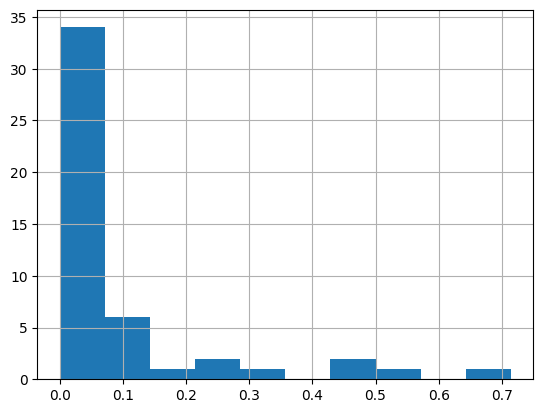

In [106]:
rules[rules['sanity_passed']]['detector_precisions'].apply(lambda x: x[-1] if len(x) else 0).hist()

In [133]:
rules[rules['sanity_passed']]['detector_precisions'].apply(lambda x: x[-1] if len(x) else 0).mean()

0.07751570490700925

In [142]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


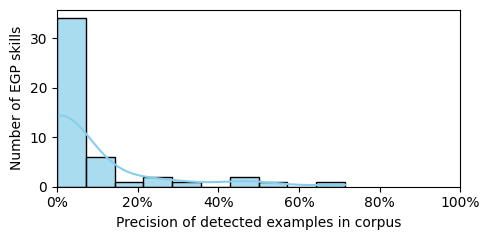

In [148]:
plt.figure(figsize=(5,2.5))
ax =sns.histplot(data=rules[rules['sanity_passed']]['detector_precisions'].apply(lambda x: x[-1] if len(x) else 0), bins=10, kde=True, color="skyblue", edgecolor='black', alpha=0.7, legend=False)
ax.set_ylabel(f"Number of EGP skills")
ax.set_xlabel("Precision of detected examples in corpus")
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
ax.set_xlim(0, 1)
plt.tight_layout()
plt.savefig('../results/auto_training.pdf')
plt.show()

In [507]:
# output dataset

output_path = '../data/auto_annotated_corpus.json'
instances = pd.DataFrame(columns=['#', 'sentence', 'positive']) if not os.path.exists(output_path) else pd.read_json(output_path)
instances['positive'] = instances['positive'].astype(bool)

In [511]:
for sentence in positives:
    new_row = pd.DataFrame({'#': [rule['#']], 'sentence': [sentence], 'positive': [False]})
    instances = pd.concat([instances, new_row], ignore_index=True)
for sentence in negatives:
    new_row = pd.DataFrame({'#': [rule['#']], 'sentence': [sentence], 'positive': [False]})
    instances = pd.concat([instances, new_row], ignore_index=True)

In [514]:
instances.to_json(output_path)